In [66]:
#in v03, I am going to limit the options to games where both teams have sufficient data. 

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import time

In [2]:
from helper_functions.clean_transitions import clean_transition_column
from helper_functions.simulate_game import simulate_game

In [3]:
avg_matrix = pd.read_excel('avg_transition_matrix_with_manual_edits.xlsx', sheet_name = 'Mean Pasted', index_col='Starting_State')

In [4]:
# def combine_matrices(matrix_A, matrix_B, avg, params=[]):
#     pass

In [5]:
#limit games to sufficient data
all_games = os.listdir('raw_game_pulls')

In [78]:
games_meta_df = pd.DataFrame()
for g in all_games:
    game_strings = g.split(' vs ')
    team_A = game_strings[0].split('for ')[-1]
    team_B = game_strings[1].split('.xlsx')[0]
    games_meta_df = pd.concat([games_meta_df, pd.DataFrame({'Game':g,
                                                            'Team A':team_A,
                                                            'Team B':team_B}, index=[0])])

In [79]:
games_meta_df=games_meta_df.reset_index(drop=True)

In [80]:
# gmd2 = games_meta_df.copy()

In [81]:
# process_1_df = games_meta_df.copy()
# process_2_df = games_meta_df.copy()

In [82]:
# t1=time.time()
# for i in tqdm(range(100)):
# games_meta_df=process_1_df.copy()
team_A_count = games_meta_df\
    .groupby('Team A')['Game']\
        .count()\
            .reset_index()\
                .rename(columns={'Game':'Team A Count'})

team_B_count = games_meta_df\
    .groupby('Team B')['Game']\
        .count()\
            .reset_index()\
                .rename(columns={'Game':'Team B Count',
                                'Team B':'Team A'})

games_meta_df=games_meta_df.merge(team_A_count, on = 'Team A', how='left')
games_meta_df=games_meta_df.merge(team_B_count, on = 'Team A', how='left')
games_meta_df=games_meta_df.fillna(0)

games_meta_df['Team A Total Games'] = games_meta_df['Team A Count'] + games_meta_df['Team B Count']

games_meta_df=games_meta_df.drop(["Team A Count", 'Team B Count'], axis=1)

games_meta_df=games_meta_df.merge(team_A_count, left_on = 'Team B', right_on='Team A', how='left')
games_meta_df=games_meta_df.merge(team_B_count, left_on = 'Team B', right_on='Team A', how='left')
games_meta_df=games_meta_df.fillna(0)

games_meta_df['Team B Total Games'] = games_meta_df['Team A Count'] + games_meta_df['Team B Count']
games_meta_df=games_meta_df.drop(["Team A Count", 'Team B Count', 'Team A_y','Team A'], axis=1).rename(columns={'Team A_x': 'Team A'})
# t2=time.time()

In [83]:
#this was just to test looping method speed - was ~59x slower than groupby method
# unique_teams = pd.Series(list(gmd2['Team A']) + list(gmd2['Team B'])).unique()
# t3=time.time()
# for i in tqdm(range(100)):
#     gmd2=process_2_df.copy()
#     for t in unique_teams:
#         total_games = int(len(gmd2[gmd2['Team A']==t])) + int(len(gmd2[gmd2['Team B']==t]))
#         gmd2.loc[gmd2['Team A']==t, 'Team A Total Games'] = total_games
#         gmd2.loc[gmd2['Team B']==t, 'Team B Total Games'] = total_games
# t4=time.time()

In [107]:
n_cutoff = 20

In [108]:
games_meta_df[(games_meta_df['Team A Total Games']>n_cutoff)&(games_meta_df['Team B Total Games']>n_cutoff)]

,Game,Team A,Team B,Team A Total Games,Team B Total Games
0,6195965_Play-By-Play for Indiana vs Army West ...,Indiana,Army West Point,25.0,28.0
1,6195966_Play-By-Play for Indiana vs Wright St....,Indiana,Wright St.,25.0,26.0
2,6195967_Play-By-Play for Indiana vs UConn.xlsx,Indiana,UConn,25.0,26.0
3,6195968_Play-By-Play for Indiana vs Harvard.xlsx,Indiana,Harvard,25.0,23.0
4,6195969_Play-By-Play for Indiana vs Auburn.xlsx,Indiana,Auburn,25.0,25.0
...,...,...,...,...,...
4804,6201017_Play-By-Play for Milwaukee vs Youngsto...,Milwaukee,Youngstown St.,27.0,28.0
4805,6201018_Play-By-Play for Cornell vs Yale.xlsx,Cornell,Yale,21.0,25.0
4806,6201019_Play-By-Play for Dartmouth vs Penn.xlsx,Dartmouth,Penn,22.0,24.0
4807,6201020_Play-By-Play for Quinnipiac vs Fairfie...,Quinnipiac,Fairfield,26.0,27.0


In [110]:
games_to_consider = list(games_meta_df[(games_meta_df['Team A Total Games']>n_cutoff)&(games_meta_df['Team B Total Games']>n_cutoff)]['Game'].unique())

In [97]:
def accuracy(simulation_outcome, game_result):
    real_A_score = game_result.iloc[-1]['Home']
    real_B_score = game_result.iloc[-1]['Away']

    sim_A_score=[simulation_outcome[1][x][0] for x in range(len(simulation_outcome[1]))]
    sim_B_score=[simulation_outcome[1][x][1] for x in range(len(simulation_outcome[1]))]
    a_error = (real_A_score-sim_A_score)**2
    b_error = (real_B_score-sim_B_score)**2

    return np.mean(np.sqrt(a_error+b_error))

In [98]:
def accuracy_ou(simulation_outcome, game_result):
    real_A_score = game_result.iloc[-1]['Home']
    real_B_score = game_result.iloc[-1]['Away']

    real_total = real_A_score + real_B_score

    sim_A_score=[simulation_outcome[1][x][0] for x in range(len(simulation_outcome[1]))]
    sim_B_score=[simulation_outcome[1][x][1] for x in range(len(simulation_outcome[1]))]
    sim_total = np.array(list(map(lambda x,y: x+y, sim_B_score, sim_A_score)))


    return np.mean(sim_total-real_total)

In [172]:
def accuracy_winner(simulation_outcome, game_result):
    real_A_score = game_result.iloc[-1]['Home']
    real_B_score = game_result.iloc[-1]['Away']

    team_A_win = real_A_score > real_B_score

    sim_A_score=np.array([simulation_outcome[1][x][0] for x in range(len(simulation_outcome[1]))])
    sim_B_score=np.array([simulation_outcome[1][x][1] for x in range(len(simulation_outcome[1]))])
    sim_win = sim_A_score > sim_B_score


    return np.mean(team_A_win == sim_win)

In [191]:
# Define optimization problem
def optimization_problem(scalar_multiples):
    # global m1, m2, m3, matrix1, matrix2, combined_matrix, checked

    #choose n random games to simulate

    accuracy_list = []
    ou_list = []
    winner_list = []
    for g in np.random.choice(games_to_consider, 100):
        total_acc=0
        # game_res = pd.read_excel('raw_game_pulls/6195965_Play-By-Play for Indiana vs Army West Point.xlsx')

        #locate teams to find matrices
        game_res = pd.read_excel('raw_game_pulls/{}'.format(g))
        game_strings = g.split(' vs ')
        team_A = game_strings[0].split('for ')[-1]
        team_B = game_strings[1].split('.xlsx')[0]

        matrix1 = pd.read_excel('team_specific_matrix/{}_A.xlsx'.format(team_A), index_col='Starting_State')
        matrix2 = pd.read_excel('team_specific_matrix/{}_B.xlsx'.format(team_B), index_col='Starting_State')


        # Reshape the parameters into matrices
        m1 = scalar_multiples[:18].reshape(-1, 1)
        m2 = scalar_multiples[18:36].reshape(-1, 1)
        m3 = scalar_multiples[36:].reshape(-1, 1)

        # Construct combined matrix
        # combined_matrix = m1 * matrix1 + m2 * matrix2 + m3 * avg_matrix  # Adjust with scalar multiples
        combined_matrix = pd.DataFrame()
        for i in range(18):
            combined_matrix[i] = matrix1.iloc[:, i] * m1[i] + \
                                matrix2.iloc[:, i] * m2[i] + \
                                avg_matrix.iloc[:, i] * m3[i]
            
        combined_matrix.columns=avg_matrix.columns
        
        for r in combined_matrix.index:
            if combined_matrix.loc[r].sum()==0.:
                combined_matrix.loc[r]=avg_matrix.loc[r].copy()
            
        combined_matrix = combined_matrix.div(combined_matrix.sum(axis=1), axis=0)
        combined_matrix.columns=avg_matrix.columns

        # Evaluate performance on X game simulations
        result = simulate_game(combined_matrix, 10)
        total_acc += accuracy(result, game_res)
        accuracy_list.append(accuracy(result, game_res))
        ou_list.append(accuracy_ou(result, game_res))
        winner_list.append(accuracy_winner(result, game_res))
        
    # scalar_history.append(scalar_multiples)
    # acc_history.append(np.mean(total_acc))
    return accuracy_list, ou_list, winner_list

In [192]:
# Initialize parameters
# initial_guess = np.random.rand(54)
    
initial_guess=   [1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,
                    0,0,0,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Define bounds for parameters (optional)
bounds = [(0, 1)] * 54  # Non-negative scalar multiples

In [193]:
team_A_guess = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
team_B_guess = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
avg_guess = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])


In [194]:
# guesses = [initial_guess, team_A_guess, team_B_guess,mean_teams,halves]

In [195]:
# for g in guesses:
#     res = optimization_problem(np.array(g))
#     acc_history.append(res)

In [196]:
#this accuracy came with initial guess, team A only, team B only, mean teams, and mean all.

acc_history = [15.292806853524496,
 15.57244836198554,
 18.087572077402445,
 18.13050025120224,
 19.490909061580126]

In [197]:
g_avg = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                     0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                     1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

In [198]:
g1 = np.array([1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,
    0,0,0,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

g2 = (g1 + g_avg)*.5

g3 = g1 * 0.9 + g_avg * .1

g4 = g1 * .8 + g_avg * .1

g5 = g1 * .5 + g_avg * .1

g6 = np.array([1,1,1,1,1, 0, 0, 0,1,0,0,0,0,0,.5,.5,.5,0,
               0,0,0,0,0,.5,.5,.5,0,1,1,1,1,1, 0, 0, 0,1,
               0,0,0,0,0, 0, 0, 0,0,0,0,0,0,0, 0, 0, 0,0])

In [199]:
g7 = np.array([1,1,1,1,1, 0, 0, 0,1,0,0,0,0,0,.2,.2,.2,0,
               0,0,0,0,0,.2,.2,.2,0,1,1,1,1,1, 0, 0, 0,1,
               0,0,0,0,0, 0, 0, 0,0,0,0,0,0,0, 0, 0, 0,0])

g8 = np.array([1,1,1,1,1, 0, 0, 0,1,0,0,0,0,0,.8,.8,.8,0,
               0,0,0,0,0,.8,.8,.8,0,1,1,1,1,1, 0, 0, 0,1,
               0,0,0,0,0, 0, 0, 0,0,0,0,0,0,0, 0, 0, 0,0])

In [216]:
# new guesses test
g_1_variation_1 = np.array([2,1,.5,1,2,0,0,0,1,0,0,0,0,0,.5,1,2,0,
    0,0,0,0,0,1,.5,1,0,2,1,.5,1,1,0,0,0,2,
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

g_1_variation_2 = np.array([1,2,1,2,1,0,0,0,2,0,0,0,0,0,1,2,1,0,
    0,0,0,0,0,2,1,2,0,1,2,1,2,1,0,0,0,2,
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

g_1_variation_3 = g1*np.random.choice([1,2,3,4,5,6,7,8,9,10], 54)

In [218]:
lob = []
acc_history=[]
ou_history = []
winner_history = []

gsss = [avg_guess, g1, g_1_variation_1, g_1_variation_2, g_1_variation_3, g8]
for guess in tqdm(range(len(gsss))):
        # for i in range(10):
        res1, res2, res3 = optimization_problem(np.array(gsss[guess]))
        acc_history+=res1
        ou_history+=res2
        winner_history+=res3
        rep_lob = list(np.repeat(guess,len(res1)))
        lob+=rep_lob

100%|██████████| 6/6 [05:02<00:00, 50.47s/it]


In [220]:
results_plot_1 = pd.DataFrame(zip(lob,acc_history))
results_plot_2 = pd.DataFrame(zip(lob,ou_history))

results_plot_3 = pd.DataFrame(zip(lob,winner_history))

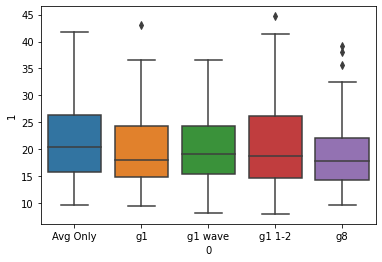

In [225]:
fig,ax=plt.subplots()
sns.boxplot(x=0, y=1, data=results_plot_1[results_plot_1[0]!=4])#, labels = ['g1','g2','g3','g4','g5','g8'])
ax.set_xticklabels(['Avg Only', 'g1', 'g1 wave', 'g1 1-2', 'g8']);

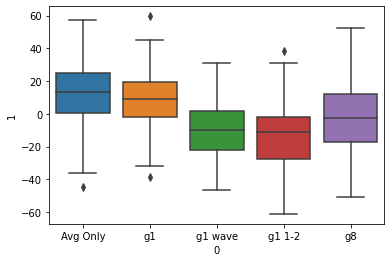

In [226]:
fig,ax=plt.subplots()
sns.boxplot(x=0, y=1, data=results_plot_2[results_plot_2[0]!=4])#, labels = ['g1','g2','g3','g4','g5','g8'])
ax.set_xticklabels(['Avg Only', 'g1', 'g1 wave', 'g1 1-2', 'g8']);

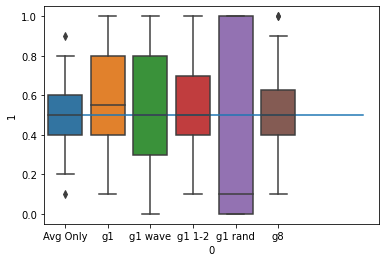

In [223]:
fig,ax=plt.subplots()
sns.boxplot(x=0, y=1, data=results_plot_3)
plt.plot(np.arange(0,8), np.repeat(0.5, len(np.arange(0,8))))
ax.set_xticklabels(['Avg Only', 'g1', 'g1 wave', 'g1 1-2', 'g1 rand', 'g8']);

In [215]:
results_plot_3

,0,1
0,0,0.5
1,0,0.3
2,0,0.9
3,0,0.6
4,0,0.7
...,...,...
895,8,0.1
896,8,0.5
897,8,0.3
898,8,0.4


In [133]:
results_plot_3

,0,1
0,0,False
1,0,True
2,0,False
3,0,False
4,0,False
...,...,...
85,8,True
86,8,False
87,8,False
88,8,False


In [ ]:
#test results first time around - g8 undershoots the OU, all others overshoot by about 10

In [ ]:
#pure distance accuracy tests is not yielding promising results.
#other accuracy tests to perform - winner, margin, and O/U total.

In [90]:
# Define optimization problem
def optimization_problem_2(scalar_multiples):
    # global m1, m2, m3, matrix1, matrix2, combined_matrix, checked
    for g in np.random.choice(os.listdir('raw_game_pulls'),100):
        total_acc=0
        # game_res = pd.read_excel('raw_game_pulls/6195965_Play-By-Play for Indiana vs Army West Point.xlsx')
        game_res = pd.read_excel('raw_game_pulls/{}'.format(g))
        game_strings = g.split(' vs ')
        team_A = game_strings[0].split('for ')[-1]
        team_B = game_strings[1].split('.xlsx')[0]

        matrix1 = pd.read_excel('team_specific_matrix/{}_A.xlsx'.format(team_A), index_col='Starting_State')
        matrix2 = pd.read_excel('team_specific_matrix/{}_B.xlsx'.format(team_B), index_col='Starting_State')


        # Reshape the parameters into matrices
        m1 = scalar_multiples[:18].reshape(-1, 1)
        m2 = scalar_multiples[18:36].reshape(-1, 1)
        m3 = scalar_multiples[36:].reshape(-1, 1)

        # Construct combined matrix
        # combined_matrix = m1 * matrix1 + m2 * matrix2 + m3 * avg_matrix  # Adjust with scalar multiples
        combined_matrix = pd.DataFrame()
        for i in range(18):
            combined_matrix[i] = matrix1.iloc[:, i] * m1[i] + \
                                matrix2.iloc[:, i] * m2[i] + \
                                avg_matrix.iloc[:, i] * m3[i]
            
        combined_matrix.columns=avg_matrix.columns
        
            
        
            
            #this is constantly failing. Instead, I am just going to force all matrices
            #to have the same lines for Af3 and Bf3
        for r in combined_matrix.index:
            if combined_matrix.loc[r].sum()==0.:
                combined_matrix.loc[r]=avg_matrix.loc[r].copy()
            
        combined_matrix = combined_matrix.div(combined_matrix.sum(axis=1), axis=0)
        combined_matrix.columns=avg_matrix.columns

        # Evaluate performance
        result = simulate_game(combined_matrix, 1)
        total_acc += accuracy_ou(result, game_res)
    # scalar_history.append(scalar_multiples)
    # acc_history.append(np.mean(total_acc))
    return np.mean(total_acc)

In [91]:
lob_2 = []
gsss = [g1,g2,g3,g4,g5,g6,g7,g8]
acc_history_2 = []
for guess in tqdm(range(len(gsss))):
        for i in range(10):
                res = optimization_problem_2(gsss[guess])
                acc_history_2.append(res)
                lob_2.append(guess)

 12%|█▎        | 1/8 [02:01<14:10, 121.47s/it]Exception ignored in: <function ZipFile.__del__ at 0x0000022949E1CC10>
Traceback (most recent call last):
  File "c:\Users\mdona\anaconda3\lib\zipfile.py", line 1816, in __del__
    self.close()
KeyboardInterrupt: 
